In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2

df = pd.read_csv("data/in_situ_rates_compiled_allvar.csv")

df.columns

Index(['Depth', 'Source', 'Source_abbrev', 'Latitude', 'Longitude', 'Sample',
       'Material', 'Rate_sa', 'Rate_error_sa', 'Organics', 'Device',
       'Deployment_d', 'Biogenic', 'Year', 'Comments', 'Mesh', 'Rate_mass',
       'Month', 'Size', 'Fragmentation_pct', 'Rate_error_mass', 'Temp_CDisk4',
       'pH_CDisk4_T25', 'Salinity_CDisk4', 'TA_CDisk4', 'DIC_CDisk4_calc13',
       'Oca_CDisk4_calc13', 'Oar_CDisk4_calc13', 'Omega_CDisk4_calc13',
       'Pressure', 'Temp_woa', 'Temp_SD_woa', 'Sal_woa', 'Sal_SD_woa',
       'Doxy_woa', 'Doxy_SD_woa', 'PO4_woa', 'SiOH4_woa', 'TA_cb', 'DIC_cb',
       'NO3_cb', 'PO4_cb', 'SiOH4_cb', 'pH_insitu_cb', 'k_calcite_calc23',
       'Oca_calc23', 'k_aragonite_calc23', 'Oar_calc23',
       'total_calcium_calc23', 'CO2_calc23', 'HCO3_calc23', 'CO3_calc23',
       'Omega_calc23', 'Oca_metab_calc12', 'Oar_metab_calc12',
       'Omega_metab_calc12'],
      dtype='object')

In [2]:
pyco2.uncertainty_OEDG18

{'pk_CO2': 0.002,
 'pk_carbonic_1': 0.0075,
 'pk_carbonic_2': 0.015,
 'pk_borate': 0.01,
 'pk_water': 0.01,
 'pk_aragonite': 0.02,
 'pk_calcite': 0.02,
 'total_borate__f': 0.02}

## Uncertainty from WOA: 
1. get WOA uncertainty (SD) for T, S, Doxy
2. run CANYON-B with (dT, dS, dO2 = 0.01 for now)
    1. no adjustments 
    2.  T + dT
    3.  S + dS
    4.  O + dO

3. calculate SD for TA, DIC, Phosphate, Silicate

### Get the derivatives and uncertainty/SD for variables that are used in PyCO2Sys
for example: how much does TA change with Temperature?

**Eq 1:** $\frac{d(TA)}{dT} = \frac{(2) - (1)}{dT}$


uncertainty:

**Eq 2:** $\sigma^2 (TA) = (\frac{dTA}{dT})^2 \cdot \sigma^2(T) + (\frac{dTA}{dS})^2 \cdot \sigma^2(S) + (\frac{dTA}{dO2})^2 \cdot \sigma^2(O2)$

In [3]:
canyonb_dT = pd.read_csv("data/compiled_WOA_CANYONBresults_uncertainty_dT.csv")
canyonb_dS = pd.read_csv("data/compiled_WOA_CANYONBresults_uncertainty_dS.csv")
canyonb_dO2 = pd.read_csv("data/compiled_WOA_CANYONBresults_uncertainty_dO2.csv")


canyonb_dx = {'dT': canyonb_dT,
        'dS': canyonb_dS,
        'dO2': canyonb_dO2}

variables = ['TA', 'DIC', 'pH_insitu', 'SiOH4', 'PO4']


In [4]:
# make column for EQUATION 1 (in canyonb dataset)
# dx is string, 'dT', 'dS', dO2
# var is is the variable in the array variables
def derivative_dx(var, dx):
    delta = 0.001 # I used the same value for dT, dS, dO2
    canyonb_dx[dx][var+'_'+dx] = (canyonb_dx[dx][var] - df[var+'_cb']) / delta
    

for dx in canyonb_dx.keys():
    for v in variables:
        derivative_dx(v, dx)    

In [5]:
# new column for EQUATION 2 (in df)

# Alkalinity
df['u_TA_woa'] = np.sqrt(canyonb_dT['TA_dT']**2 * df['Temp_SD_woa']**2 +
                              canyonb_dS['TA_dS']**2 * df['Sal_SD_woa']**2 +
                              canyonb_dO2['TA_dO2']**2 * df['Doxy_SD_woa']**2)

# DIC
df['u_DIC_woa'] = np.sqrt(canyonb_dT['DIC_dT']**2 * df['Temp_SD_woa']**2 +
                              canyonb_dS['DIC_dS']**2 * df['Sal_SD_woa']**2 +
                              canyonb_dO2['DIC_dO2']**2 * df['Doxy_SD_woa']**2)

# pH
df['u_pH_insitu_woa'] = np.sqrt(canyonb_dT['pH_insitu_dT']**2 * df['Temp_SD_woa']**2 +
                              canyonb_dS['pH_insitu_dS']**2 * df['Sal_SD_woa']**2 +
                              canyonb_dO2['pH_insitu_dO2']**2 * df['Doxy_SD_woa']**2)


# Silicate
df['u_SiOH4_woa'] = np.sqrt(canyonb_dT['SiOH4_dT']**2 * df['Temp_SD_woa']**2 +
                              canyonb_dS['SiOH4_dS']**2 * df['Sal_SD_woa']**2 +
                              canyonb_dO2['SiOH4_dO2']**2 * df['Doxy_SD_woa']**2)

# Phosphate
df['u_PO4_woa'] = np.sqrt(canyonb_dT['PO4_dT']**2 * df['Temp_SD_woa']**2 +
                              canyonb_dS['PO4_dS']**2 * df['Sal_SD_woa']**2 +
                              canyonb_dO2['PO4_dO2']**2 * df['Doxy_SD_woa']**2)


## uncertainty from CANYON-B
CANYON-B paper: https://www.frontiersin.org/articles/10.3389/fmars.2018.00328/full

information can be found in Table 2: https://www.frontiersin.org/files/Articles/340855/fmars-05-00328-HTML/image_m/fmars-05-00328-t002.jpg
- for 50th and 90th percentile
- DIC: 8.8 / 10.3 umol/kg
- Alk: 8.9 / 9.3
- pH: 0.018 / 0.019
- PO4: 0.071 / 0.080
- Si: 2.8 / 3.9

adding this uncertainty to the uncertainty from WOA data, like this:

**Eq 3:** $\sigma^2 (TA) =  \sigma^2(TA_{WOA}) + \sigma^2(TA_{CANYON-B})$

In [6]:
# uncertainties from CANYON-B, using 90th percentile
sigma_canyonb = {'TA': 9.3,
                'DIC': 10.3,
                 'pH_insitu': 0.019,
                'PO4': 0.080,
                'SiOH4': 3.9}


# calculate total uncertainty from WOA and CANYON-B

# Alkalinity
df['u_TA_woa_cb'] = np.sqrt(df['u_TA_woa']**2 + sigma_canyonb['TA']**2)
# DIC
df['u_DIC_woa_cb'] = np.sqrt(df['u_DIC_woa']**2 + sigma_canyonb['DIC']**2)
# pH
df['u_pH_insitu_woa_cb'] = np.sqrt(df['u_pH_insitu_woa']**2 + sigma_canyonb['pH_insitu']**2)
# PO4
df['u_PO4_woa_cb'] = np.sqrt(df['u_PO4_woa']**2 + sigma_canyonb['PO4']**2)
# SiOH4
df['u_SiOH4_woa_cb'] = np.sqrt(df['u_SiOH4_woa']**2 + sigma_canyonb['SiOH4']**2)


## uncertainty propagation in PyCO2SYS

In [7]:
u_results = pyco2.sys(par1=df["DIC_cb"], 
                    par2=df["pH_insitu_cb"], 
                    par1_type = 2, par2_type=3, 
                    salinity=df["Sal_woa"], 
                    temperature=df["Temp_woa"], 
                    pressure=df["Pressure"],
                    total_silicate=df["SiOH4_cb"], 
                    total_phosphate=df["PO4_cb"],
                  uncertainty_into=["saturation_calcite", "saturation_aragonite"],
                  uncertainty_from={
                      "par1": df['u_DIC_woa_cb'],
                      "par2": df['u_pH_insitu_woa_cb'],
                      "salinity": df['Sal_SD_woa'] ,                   
                      "temperature": df['Temp_SD_woa'],
                      "total_silicate": df['u_SiOH4_woa_cb'],
                      "total_phosphate": df['u_PO4_woa_cb']})

In [8]:
#add the columns that I find necessary
df[["u_Oca_calc23", "u_Oar_calc23"]] = pd.DataFrame(u_results)[['u_saturation_calcite', 'u_saturation_aragonite']]

#make an extra column that is just "Omega" 
#which either takes the saturation_calcite or saturation_aragonite value, depending on material type
df["u_Omega_calc23"] = np.where(df["Material"].eq("Aragonite"), df["u_Oar_calc23"], df["u_Oca_calc23"])

#except for nan or Mg Calcite
df.loc[((df["Material"] == "Mg-Calcite") | (pd.isna(df["Material"]))), "u_Omega_calc23"] = np.nan
df.loc[((df["Material"] == "Silica") | (pd.isna(df["Material"]))), "u_Omega_calc23"] = np.nan

# save
df.to_csv("data/in_situ_rates_compiled_allvar_uncertainty.csv", index=False)

In [9]:
df["u_Oca_calc23"].count()

752

## Plot uncertainty (Figure S13)

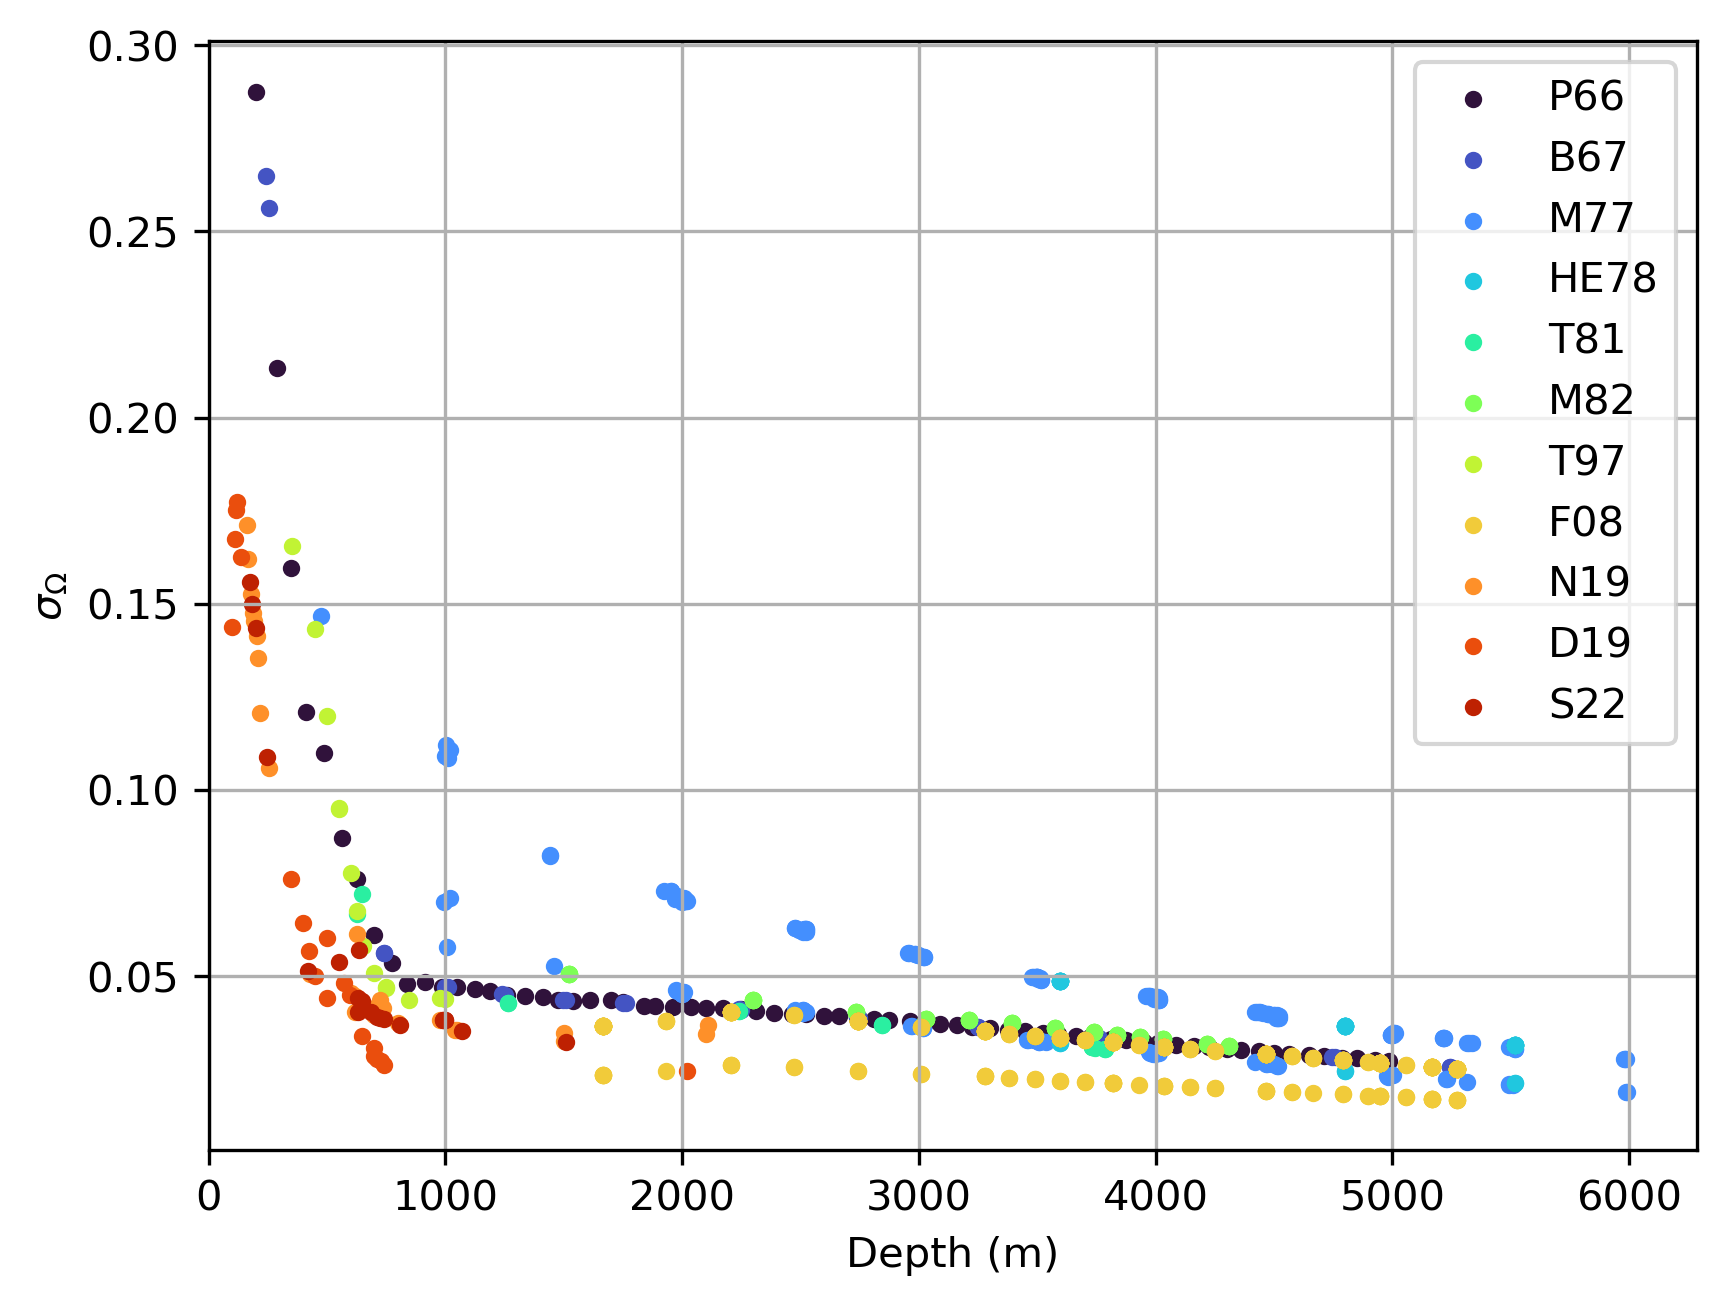

In [10]:
import pylab
NUM_COLORS = len(df["Source_abbrev"].unique())
cm = pylab.get_cmap('turbo')
colors = []
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)
    colors.append(color)
    
plt.figure(dpi=300)


for n,s in enumerate(df['Source_abbrev'].unique()):
    #if s != 'p66' and s!= 't97':
    df_s = df[df['Source_abbrev'] == s]   
    plt.scatter(df_s['Depth'], df_s['u_Omega_calc23'], label=s, s=10, color=colors[n])
    
#plt.axline((1000,0.02), slope=0, linestyle='dotted')
plt.legend()
plt.grid()
#plt.ylim(0, 0.3)
plt.xlim(0)
plt.ylabel('$\sigma_{\Omega}$')
plt.xlabel('Depth (m)')
plt.show()